# Sarcasm Detection in Political Comments

In [1]:
from google.colab import drive
import os
import sys

drive.mount("/content/drive")
base_dir = "/content/drive/MyDrive/SarcasmDetection"
sys.path.append(base_dir)
os.chdir(base_dir)
# data paths
train_data_balanced_path = os.path.join(base_dir, "train-balanced-sarcasm.csv")
test_data_balanced_path = os.path.join(base_dir, "test-balanced.csv")
test_data_unbalanced_path = os.path.join(base_dir, "test-unbalanced.csv")

Mounted at /content/drive


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK resources
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Data Loading and Exploration

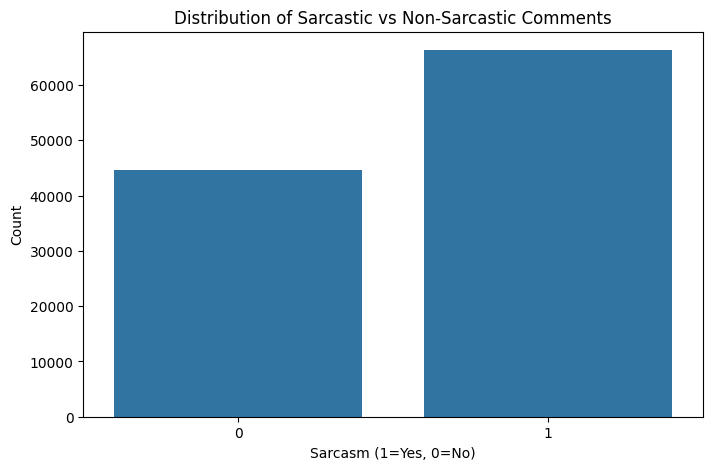

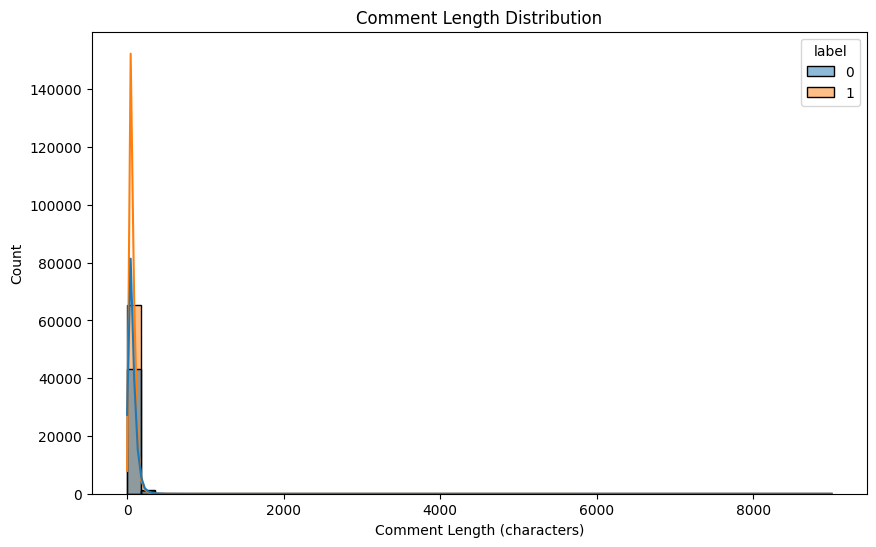

In [5]:
train_data_all = pd.read_csv(train_data_balanced_path)

# Get political data only
political_subreddits = [
    "politics", "news", "worldnews", "HillaryForPrison", "progressive", "The_Donald",
    "ukpolitics", "conspiracy", "Libertarian", "worldpolitics", "EnoughTrumpSpam",
    "FULLCOMMUNISM", "WayOfTheBern", "PoliticalDiscussion", "uncensorednews",
    "LateStageCapitalism", "Anarchism", "Conservative", "DNCleaks", "TopMindsOfReddit",
    "Republican", "PoliticalVideo", "AskAnAmerican", "AmericanPolitics", "DebateFascism",
    "socialism", "Anarcho_Capitalism", "GenderCritical", "AskThe_Donald",
    "EnoughLibertarianSpam", "CanadaPolitics"
]


train_data = train_data_all[train_data_all['subreddit'].isin(political_subreddits)]
train_data = train_data.dropna(subset=['subreddit', 'comment', 'label', 'subreddit'])

# Check class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_data)
plt.title('Distribution of Sarcastic vs Non-Sarcastic Comments')
plt.xlabel('Sarcasm (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()

# Check comment length distribution
train_data['comment_length'] = train_data['comment'].fillna('').apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='comment_length', hue='label', bins=50, kde=True)
plt.title('Comment Length Distribution')
plt.xlabel('Comment Length (characters)')
plt.ylabel('Count')
plt.show()

## 2. Text Preprocessing

In [6]:
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        # Join tokens back to text
        return ' '.join(tokens)
    else:
        return ''

# Apply preprocessing to training and test data
train_data['processed_comment'] = train_data['comment'].apply(preprocess_text)

# Remove rows with empty processed comments
train_data = train_data[train_data['processed_comment'].str.strip() != '']
print(f"Training data shape after preprocessing: {train_data.shape}")

Training data shape after preprocessing: (88108, 12)


## 3. Word Cloud Visualization

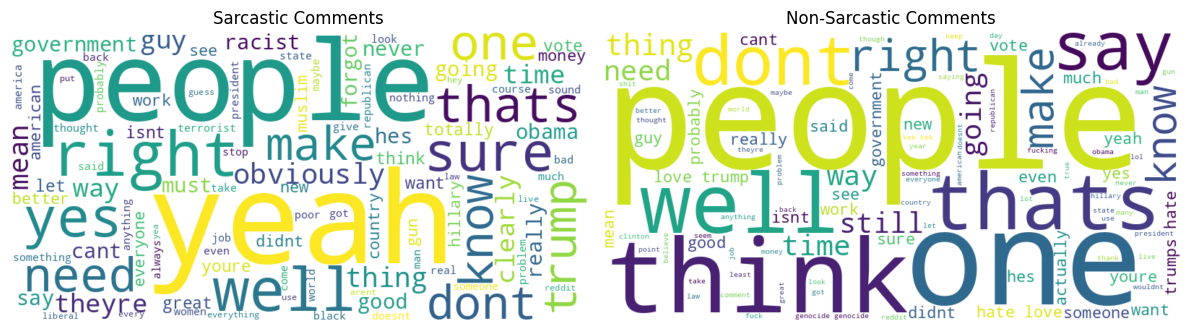

In [8]:
# Create separate text corpora for sarcastic and non-sarcastic comments
sarcastic_text = ' '.join(train_data[train_data['label'] == 1]['processed_comment'])
non_sarcastic_text = ' '.join(train_data[train_data['label'] == 0]['processed_comment'])

# Generate word clouds
plt.figure(figsize=(12, 6))

# Sarcastic comments word cloud
plt.subplot(1, 2, 1)
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white',
                               max_words=100, contour_width=3, contour_color='steelblue')
wordcloud_sarcastic.generate(sarcastic_text)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments')
plt.axis('off')

# Non-sarcastic comments word cloud
plt.subplot(1, 2, 2)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white',
                                  max_words=100, contour_width=3, contour_color='firebrick')
wordcloud_non_sarcastic.generate(non_sarcastic_text)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments')
plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Feature Extraction and Classification

Bag of Words Model Evaluation:
Accuracy: 0.6890
F1 Score (weighted): 0.6866

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.57      0.59      5597
           1       0.73      0.77      0.75      8501

    accuracy                           0.69     14098
   macro avg       0.67      0.67      0.67     14098
weighted avg       0.69      0.69      0.69     14098


TF-IDF Model Evaluation:
Accuracy: 0.6890
F1 Score (weighted): 0.6851

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.55      0.58      5597
           1       0.72      0.78      0.75      8501

    accuracy                           0.69     14098
   macro avg       0.67      0.67      0.67     14098
weighted avg       0.68      0.69      0.69     14098



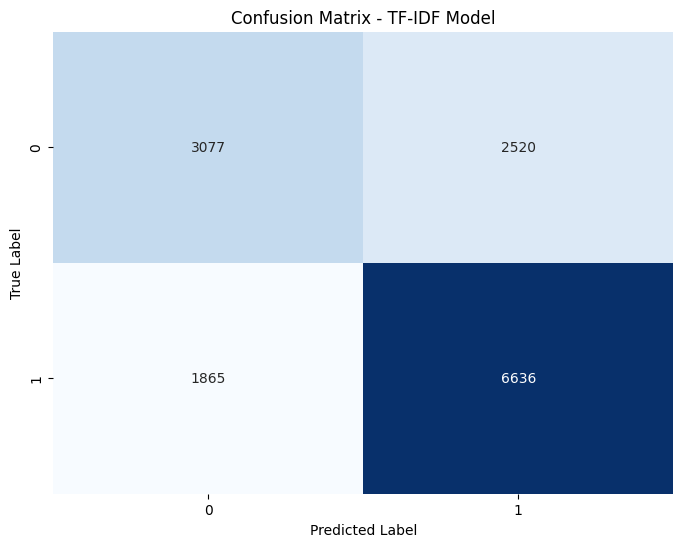


TF-IDF Model Evaluation on Balanced Test Set:
Accuracy: 0.6929
F1 Score (weighted): 0.6885


In [9]:
# Split into train and test sets
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)
# Split the preprocessed training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data['processed_comment'], train_data['label'], test_size=0.2, random_state=42)

# Approach 1: Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)

# Train Logistic Regression with BoW features
bow_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
bow_model.fit(X_train_bow, y_train)

# Evaluate on validation set
y_val_pred_bow = bow_model.predict(X_val_bow)
print("Bag of Words Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_bow):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_bow, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_bow))

# Approach 2: TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Train Logistic Regression with TF-IDF features
tfidf_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
tfidf_model.fit(X_train_tfidf, y_train)

# Evaluate on validation set
y_val_pred_tfidf = tfidf_model.predict(X_val_tfidf)
print("\nTF-IDF Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_tfidf):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_tfidf, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_tfidf))

# Confusion matrix for the better model (assuming TF-IDF is better)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred_tfidf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - TF-IDF Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Evaluate on balanced test set
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_comment'])
y_test_pred_tfidf = tfidf_model.predict(X_test_tfidf)
print("\nTF-IDF Model Evaluation on Balanced Test Set:")
print(f"Accuracy: {accuracy_score(test_data['label'], y_test_pred_tfidf):.4f}")
print(f"F1 Score (weighted): {f1_score(test_data['label'], y_test_pred_tfidf, average='weighted'):.4f}")

## 5. LDA Topic Modeling

Top topics in sarcastic comments:
Topic #0: obviously, great, things, free, god, like, true, thats, bernie, shit
Topic #1: sure, need, hes, think, time, hillary, government, president, hey, dont
Topic #2: dont, forgot, want, better, say, guy, arent, let, fuck, theres
Topic #3: know, war, trying, israel, needs, literally, live, thanks, dropped, idea
Topic #4: yeah, money, bad, lets, women, make, maybe, probably, people, work
Topic #5: didnt, guys, really, yeah, yea, good, use, right, best, person
Topic #6: white, people, racist, mean, country, way, like, got, yeah, poor
Topic #7: like, right, trump, theyre, doesnt, vote, going, people, course, years
Topic #8: yes, thats, youre, totally, good, yeah, thing, world, people, guns
Topic #9: isnt, obama, dont, clearly, black, thought, real, america, yeah, news

Top topics in non-sarcastic comments:
Topic #0: family, news, man, hope, exactly, little, public, start, try, nice
Topic #1: didnt, genocide, like, want, hillary, sure, dont, states, pr

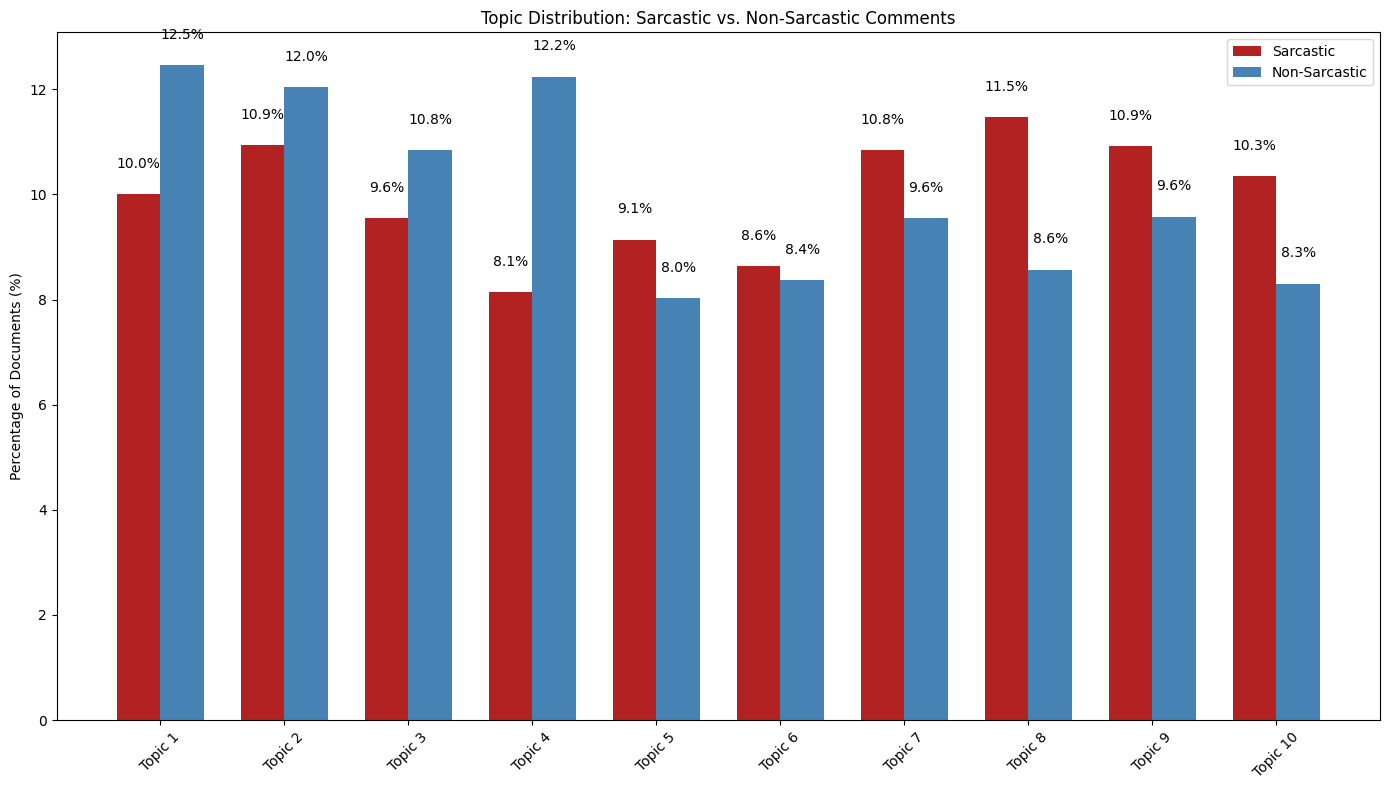

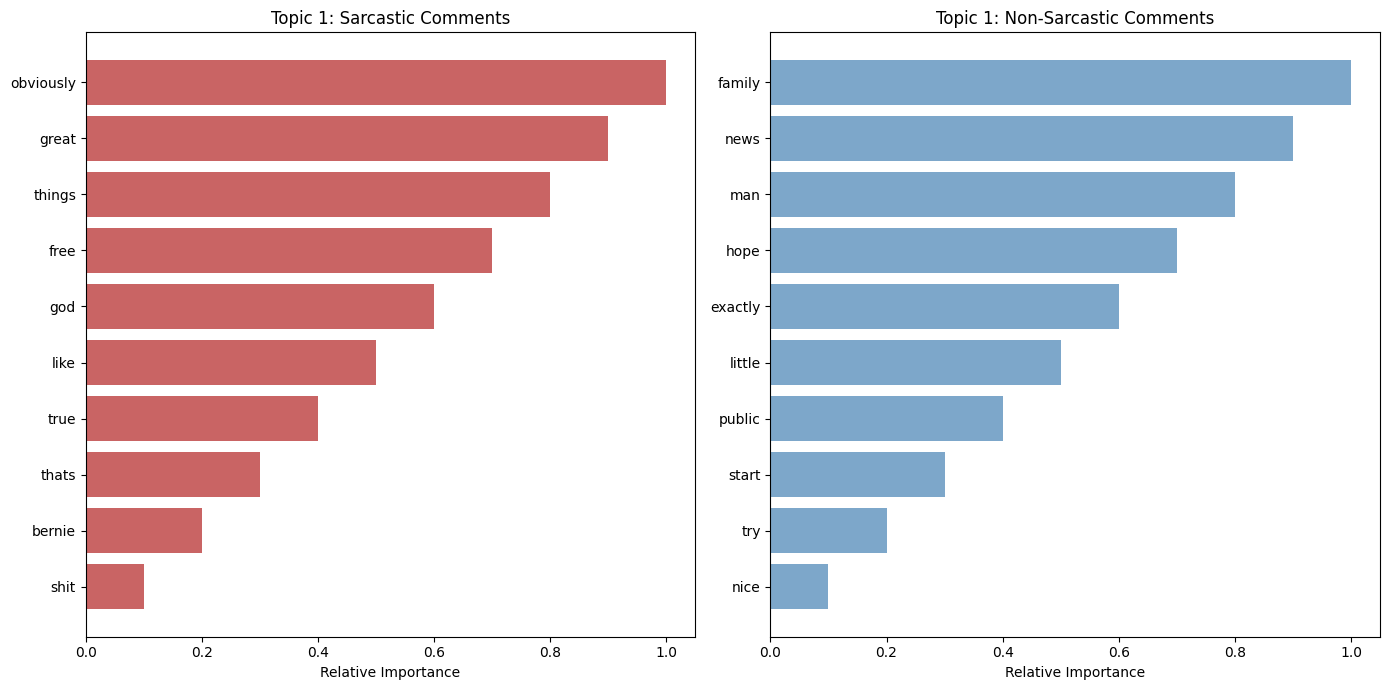

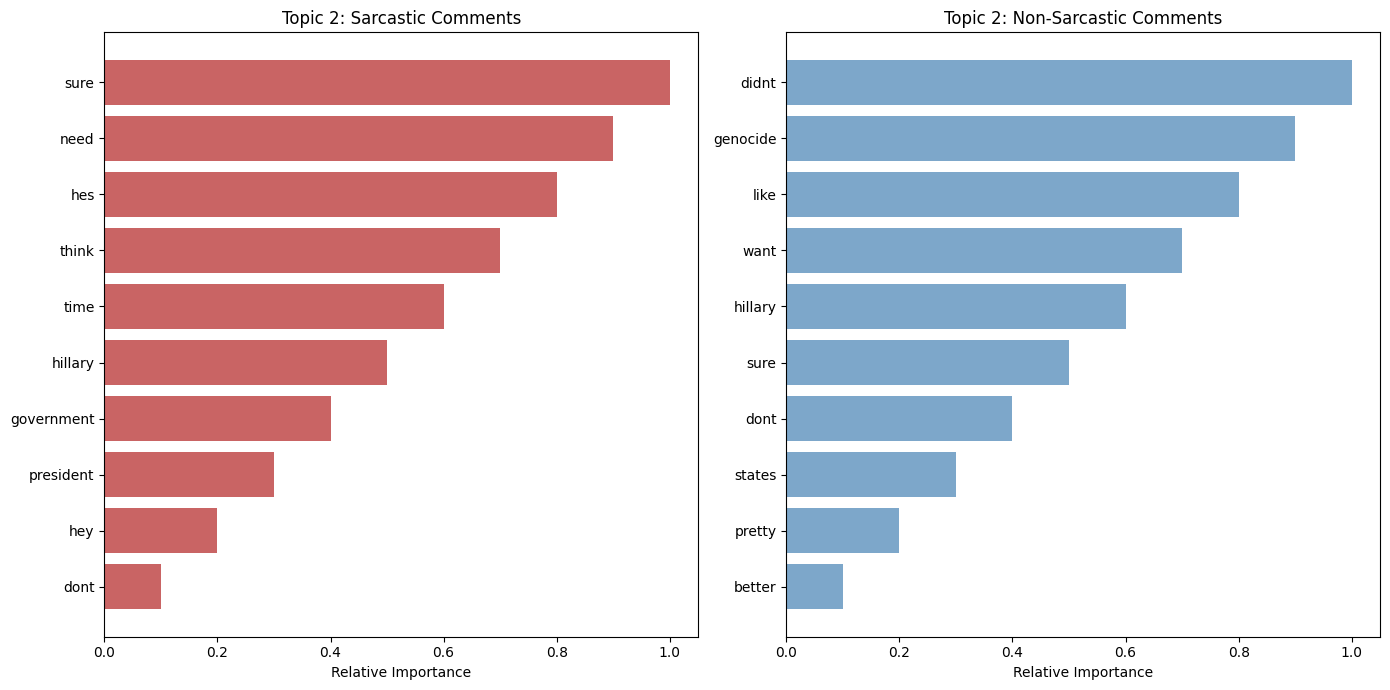

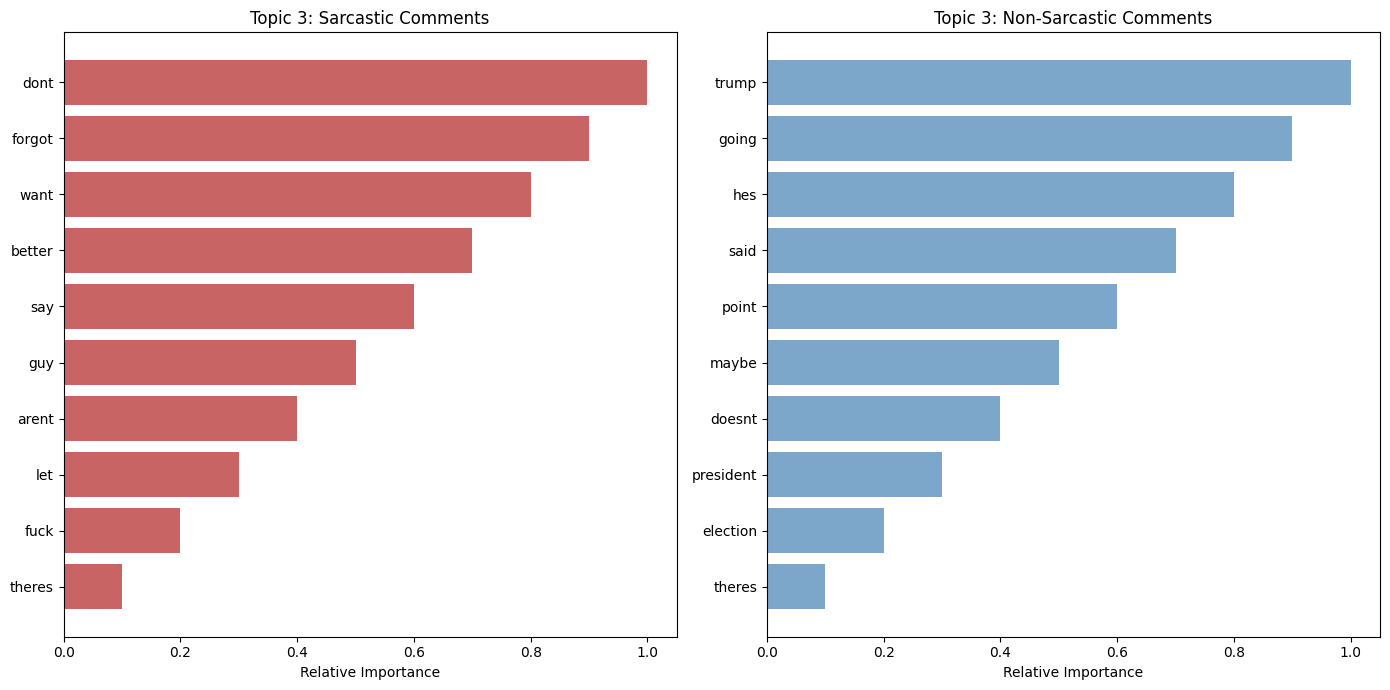

,Topic Number,Sarcastic Top Words,Non-Sarcastic Top Words,Sarcastic Prevalence (%),Non-Sarcastic Prevalence (%),Difference (%)
7,8,"like, right, trump, theyre, doesnt","love, like, say, money, need",11.47,8.57,2.90
9,10,"isnt, obama, dont, clearly, black","know, got, government, yes, mean",10.34,8.31,2.04
8,9,"yes, thats, youre, totally, good","thats, right, new, great, bernie",10.92,9.58,1.34
6,7,"white, people, racist, mean, country","good, really, youre, fucking, work",10.85,9.55,1.30
4,5,"yeah, money, bad, lets, women","trumps, way, yeah, thing, actually",9.14,8.03,1.12
5,6,"didnt, guys, really, yeah, yea","time, make, white, wrong, wouldnt",8.64,8.37,0.26
1,2,"sure, need, hes, think, time","didnt, genocide, like, want, hillary",10.94,12.05,-1.11
2,3,"dont, forgot, want, better, say","trump, going, hes, said, point",9.55,10.85,-1.29
0,1,"obviously, great, things, free, god","family, news, man, hope, exactly",10.01,12.46,-2.46
3,4,"know, war, trying, israel, needs","people, dont, think, hate, isnt",8.14,12.24,-4.10


In [10]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Set number of topics
n_topics = 10

# Create vectorizer for LDA
lda_vectorizer = CountVectorizer(max_features=5000,
                                stop_words='english',
                                min_df=5,
                                max_df=0.9)

# Separate sarcastic and non-sarcastic comments
sarcastic_docs = train_data[train_data['label'] == 1]['processed_comment'].tolist()
non_sarcastic_docs = train_data[train_data['label'] == 0]['processed_comment'].tolist()

# Process sarcastic comments
X_sarcastic = lda_vectorizer.fit_transform(sarcastic_docs)
feature_names = lda_vectorizer.get_feature_names_out()

# Create and fit LDA model for sarcastic comments
lda_model_sarcastic = LatentDirichletAllocation(n_components=n_topics,
                                              max_iter=50,
                                              learning_method='online',
                                              learning_offset=50.,
                                              random_state=42)
lda_model_sarcastic.fit(X_sarcastic)

# Process non-sarcastic comments with the same vocabulary
X_non_sarcastic = lda_vectorizer.transform(non_sarcastic_docs)

# Create and fit LDA model for non-sarcastic comments
lda_model_non_sarcastic = LatentDirichletAllocation(n_components=n_topics,
                                                  max_iter=50,
                                                  learning_method='online',
                                                  learning_offset=50.,
                                                  random_state=42)
lda_model_non_sarcastic.fit(X_non_sarcastic)

# Function to get top words for each topic
def display_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(top_words)
    return topics

# Get top words for each topic
sarcastic_topics = display_topics(lda_model_sarcastic, feature_names)
non_sarcastic_topics = display_topics(lda_model_non_sarcastic, feature_names)

# Print top topics
print("Top topics in sarcastic comments:")
for idx, topic in enumerate(sarcastic_topics):
    print(f"Topic #{idx}: {', '.join(topic)}")

print("\nTop topics in non-sarcastic comments:")
for idx, topic in enumerate(non_sarcastic_topics):
    print(f"Topic #{idx}: {', '.join(topic)}")

# Function to get document-topic distributions
def get_document_topics(model, X):
    return model.transform(X)

# Get document-topic distributions
sarcastic_doc_topics = get_document_topics(lda_model_sarcastic, X_sarcastic)
non_sarcastic_doc_topics = get_document_topics(lda_model_non_sarcastic, X_non_sarcastic)

# Get dominant topic for each document
sarcastic_dominant_topics = sarcastic_doc_topics.argmax(axis=1)
non_sarcastic_dominant_topics = non_sarcastic_doc_topics.argmax(axis=1)

# Count topic frequencies
sarcastic_topic_counts = np.bincount(sarcastic_dominant_topics, minlength=n_topics)
non_sarcastic_topic_counts = np.bincount(non_sarcastic_dominant_topics, minlength=n_topics)

# Normalize to get percentages
sarcastic_topic_pct = sarcastic_topic_counts / sarcastic_topic_counts.sum() * 100
non_sarcastic_topic_pct = non_sarcastic_topic_counts / non_sarcastic_topic_counts.sum() * 100

# Plot topic distribution comparison with better contrast
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.35
x = np.arange(n_topics)

sarcastic_bars = ax.bar(x - width/2, sarcastic_topic_pct, width, label='Sarcastic', color='firebrick')
non_sarcastic_bars = ax.bar(x + width/2, non_sarcastic_topic_pct, width, label='Non-Sarcastic', color='steelblue')

ax.set_xticks(x)
ax.set_xticklabels([f'Topic {i+1}' for i in range(n_topics)])
ax.set_ylabel('Percentage of Documents (%)')
ax.set_title('Topic Distribution: Sarcastic vs. Non-Sarcastic Comments')
ax.legend()

# Add value labels on top of bars
for i, v in enumerate(sarcastic_topic_pct):
    ax.text(i - width/2, v + 0.5, f'{v:.1f}%', ha='center')

for i, v in enumerate(non_sarcastic_topic_pct):
    ax.text(i + width/2, v + 0.5, f'{v:.1f}%', ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a more effective visualization of topic words
def plot_top_words(sarcastic_topics, non_sarcastic_topics, topic_num, top_n=10):
    plt.figure(figsize=(14, 7))

    # Create a comparison of top words
    sarcastic_words = sarcastic_topics[topic_num][:top_n]
    non_sarcastic_words = non_sarcastic_topics[topic_num][:top_n]

    # Plot words with importance scores
    sarcastic_importance = np.linspace(1, 0.1, top_n)
    non_sarcastic_importance = np.linspace(1, 0.1, top_n)

    # Create a horizontal bar chart
    plt.subplot(1, 2, 1)
    plt.barh(np.arange(top_n), sarcastic_importance, color='firebrick', alpha=0.7)
    plt.yticks(np.arange(top_n), sarcastic_words)
    plt.title(f'Topic {topic_num+1}: Sarcastic Comments')
    plt.xlabel('Relative Importance')
    plt.gca().invert_yaxis()  # To have most important words at the top

    plt.subplot(1, 2, 2)
    plt.barh(np.arange(top_n), non_sarcastic_importance, color='steelblue', alpha=0.7)
    plt.yticks(np.arange(top_n), non_sarcastic_words)
    plt.title(f'Topic {topic_num+1}: Non-Sarcastic Comments')
    plt.xlabel('Relative Importance')
    plt.gca().invert_yaxis()  # To have most important words at the top

    plt.tight_layout()
    plt.show()

# Visualize a few selected topics
for topic_idx in range(3):
    plot_top_words(sarcastic_topics, non_sarcastic_topics, topic_idx)

# Display topic labels with top words in a table
topic_labels = []
for i in range(n_topics):
    sarcastic_words = ", ".join(sarcastic_topics[i][:5])
    non_sarcastic_words = ", ".join(non_sarcastic_topics[i][:5])

    # Calculate prevalence
    sarcastic_prev = sarcastic_topic_pct[i]
    non_sarcastic_prev = non_sarcastic_topic_pct[i]

    # Calculate difference in prevalence
    diff = sarcastic_prev - non_sarcastic_prev

    topic_labels.append({
        'Topic Number': i+1,
        'Sarcastic Top Words': sarcastic_words,
        'Non-Sarcastic Top Words': non_sarcastic_words,
        'Sarcastic Prevalence (%)': round(sarcastic_prev, 2),
        'Non-Sarcastic Prevalence (%)': round(non_sarcastic_prev, 2),
        'Difference (%)': round(diff, 2)
    })

topic_df = pd.DataFrame(topic_labels)
topic_df = topic_df.sort_values('Difference (%)', ascending=False)
topic_df

# 6. Evaluating the Impact of Subreddits on Sarcasm

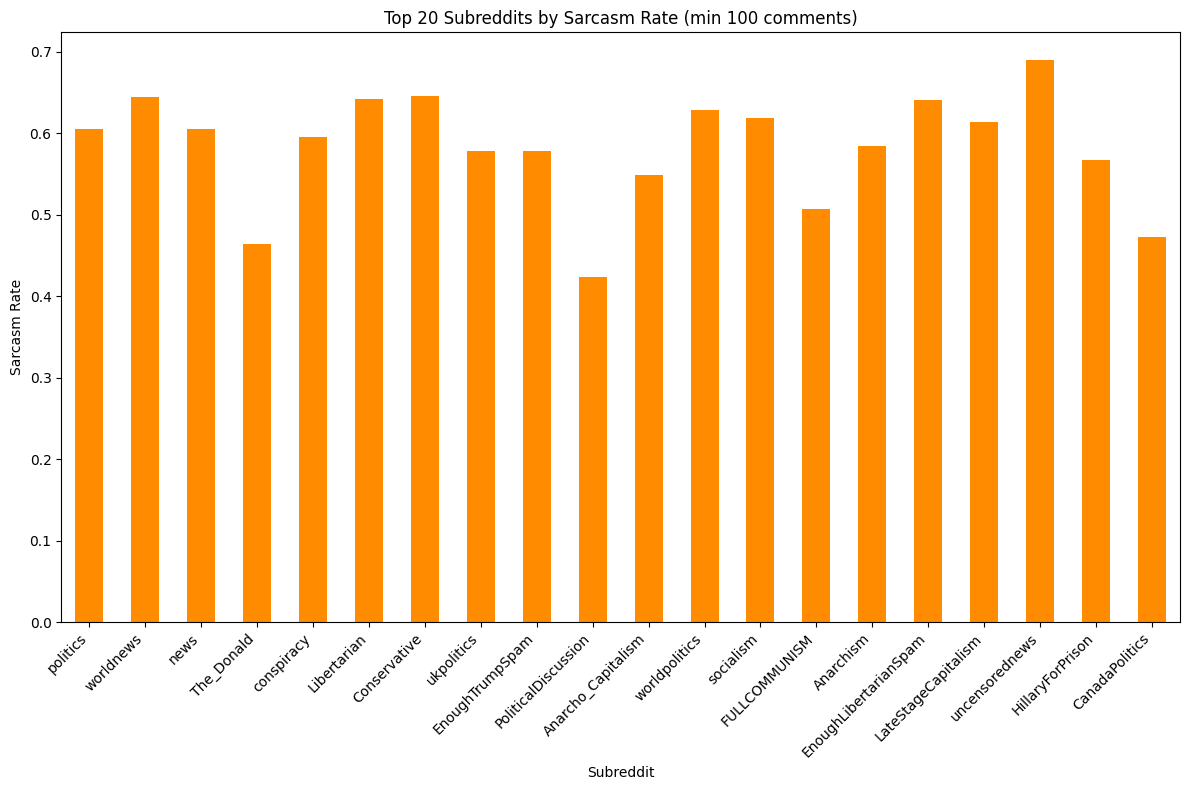

Subreddit-Only Model Evaluation:
Accuracy: 0.6077
F1 Score (weighted): 0.5319


In [11]:
# Analyzing sarcasm prevalence by subreddit
subreddit_sarcasm = train_data.groupby('subreddit')['label'].mean().sort_values(ascending=False)
subreddit_counts = train_data.groupby('subreddit').size().sort_values(ascending=False)

# Filter for subreddits with a minimum number of comments
min_comments = 100
filtered_subreddits = subreddit_counts[subreddit_counts >= min_comments].index
subreddit_sarcasm_filtered = subreddit_sarcasm[filtered_subreddits]

# Plot top 20 subreddits by sarcasm rate
plt.figure(figsize=(12, 8))
subreddit_sarcasm_filtered.head(20).plot(kind='bar', color='darkorange')
plt.title('Top 20 Subreddits by Sarcasm Rate (min 100 comments)')
plt.ylabel('Sarcasm Rate')
plt.xlabel('Subreddit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a feature for subreddit to see if it improves classification
# One-hot encode the top subreddits
top_subreddits = subreddit_counts.head(50).index.tolist()
train_data_sub = train_data.copy()
train_data_sub['subreddit'] = train_data_sub['subreddit'].apply(lambda x: x if x in top_subreddits else 'other')
subreddit_dummies = pd.get_dummies(train_data_sub['subreddit'], prefix='subreddit')
train_data_with_subreddit = pd.concat([train_data_sub, subreddit_dummies], axis=1)

# Split data with subreddit features
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    train_data_with_subreddit.drop(['label', 'comment', 'author', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment', 'processed_comment', 'comment_length', 'lda_tokens', 'subreddit'], axis=1, errors='ignore'),
    train_data_with_subreddit['label'],
    test_size=0.2,
    random_state=42
)

# Train a model with subreddit features
subreddit_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
subreddit_model.fit(X_train_sub, y_train_sub)

# Evaluate
y_val_pred_sub = subreddit_model.predict(X_val_sub)
print("Subreddit-Only Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val_sub, y_val_pred_sub):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val_sub, y_val_pred_sub, average='weighted'):.4f}")




# 7. Challanges and Solutions

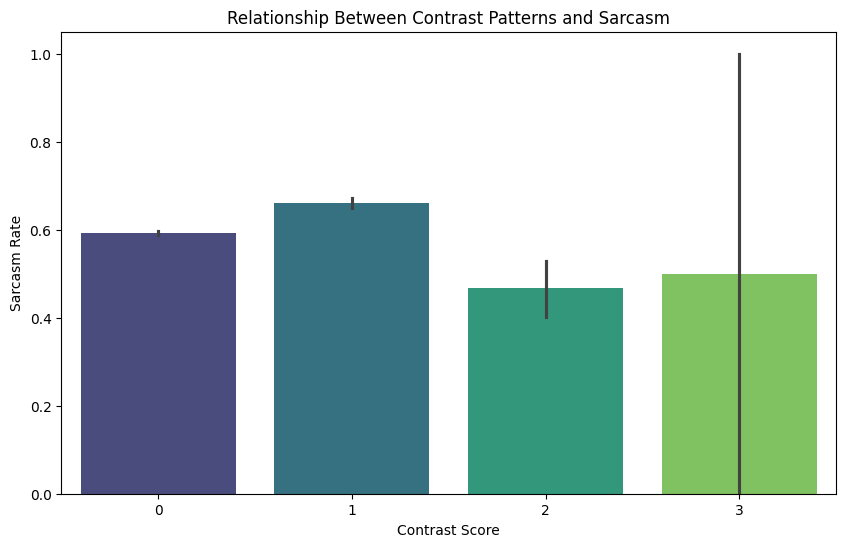

In [12]:
# Challenge: Detecting subtle sarcasm without lexical cues
# Solution: Analyze patterns of word usage indicating subtext or contrast

# Example: Identifying contrast patterns in comments
def detect_contrast(text):
    """Detect contrast patterns that might indicate sarcasm"""
    if not isinstance(text, str):
        return 0

    # List of contrast words and phrases
    contrast_words = ['but', 'however', 'although', 'though', 'yet', 'nonetheless',
                     'nevertheless', 'still', 'even so', 'on the other hand']

    # Count occurrences of contrast words
    count = sum(1 for word in contrast_words if re.search(r'\b' + word + r'\b', text.lower()))

    # Check for specific sarcasm patterns
    patterns = [
        r'\bsuuure\b',
        r'\briiiight\b',
        r'\bsuuuuure\b',
        r'\byeah right\b',
        r'\boh really\b',
        r'\bwow\b.*\breally\b',
        r'[!?]{2,}',
        r'\bgood luck with that\b',
        r"\\bi\\'m sure\\b"
    ]

    for pattern in patterns:
        if re.search(pattern, text.lower()):
            count += 1

    return min(count, 5)  # Cap at 5 for feature scaling

# Add contrast feature to the dataset if it doesn't exist
if 'contrast_score' not in train_data.columns:
    train_data['contrast_score'] = train_data['comment'].apply(detect_contrast)

# Plot relationship between contrast score and sarcasm
plt.figure(figsize=(10, 6))
sns.barplot(x='contrast_score', y='label', data=train_data, palette='viridis')
plt.title('Relationship Between Contrast Patterns and Sarcasm')
plt.xlabel('Contrast Score')
plt.ylabel('Sarcasm Rate')
plt.show()


# 8. Combined Model


Combined Model Evaluation:
Accuracy: 0.6950
F1 Score (weighted): 0.6909

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      5597
           1       0.73      0.79      0.76      8501

    accuracy                           0.69     14098
   macro avg       0.68      0.67      0.67     14098
weighted avg       0.69      0.69      0.69     14098



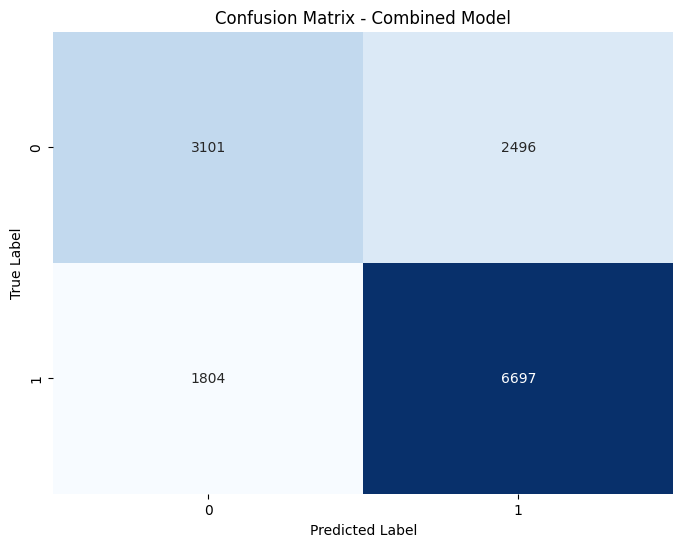

<Figure size 1200x600 with 0 Axes>

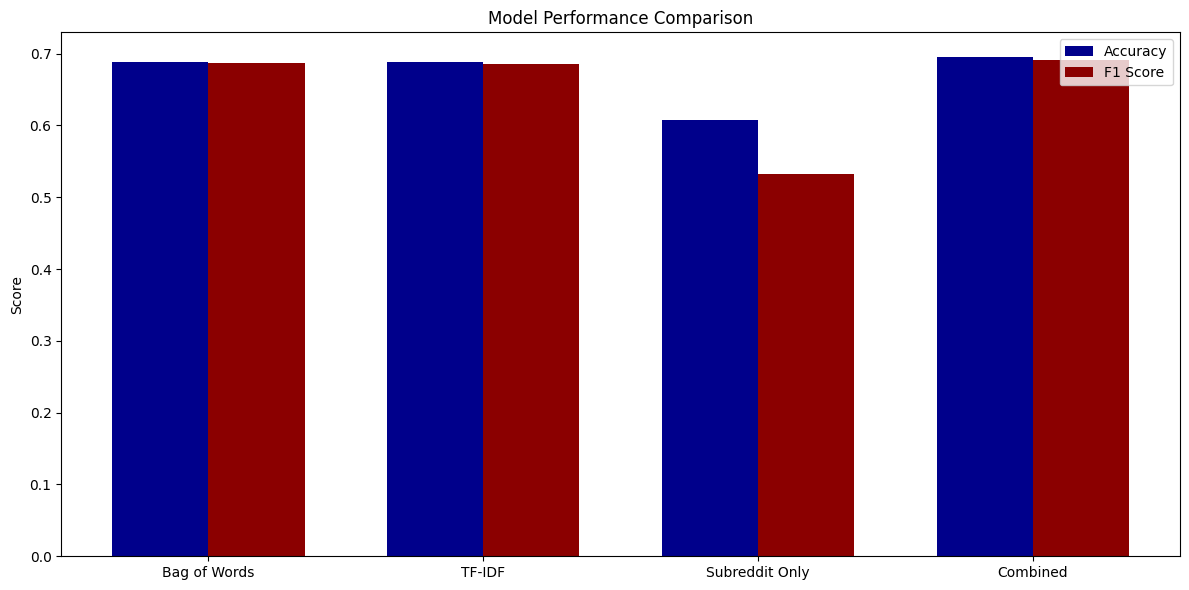

In [13]:
# Create a combined model using TF-IDF features and other metadata
# Prepare features: TF-IDF + contrast_score + subreddit

# Split data
train_final, val_final = train_test_split(train_data, test_size=0.2, random_state=42)

# TF-IDF features
tfidf_vect_final = TfidfVectorizer(max_features=5000)
X_train_tfidf_final = tfidf_vect_final.fit_transform(train_final['processed_comment'])
X_val_tfidf_final = tfidf_vect_final.transform(val_final['processed_comment'])

# Create additional features DataFrame
train_features = pd.DataFrame({
    'contrast_score': train_final['contrast_score'],
    'comment_length': train_final['comment_length']
})

val_features = pd.DataFrame({
    'contrast_score': val_final['contrast_score'],
    'comment_length': val_final['comment_length']
})

# Convert to sparse matrices and concatenate with TF-IDF features
from scipy.sparse import hstack
X_train_combined = hstack([X_train_tfidf_final, train_features.values])
X_val_combined = hstack([X_val_tfidf_final, val_features.values])

# Train the combined model
combined_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
combined_model.fit(X_train_combined, train_final['label'])

# Evaluate
y_val_pred_combined = combined_model.predict(X_val_combined)
print("Combined Model Evaluation:")
print(f"Accuracy: {accuracy_score(val_final['label'], y_val_pred_combined):.4f}")
print(f"F1 Score (weighted): {f1_score(val_final['label'], y_val_pred_combined, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(val_final['label'], y_val_pred_combined))

# Display confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(val_final['label'], y_val_pred_combined)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Combined Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compare all models - make sure previous model results are available
try:
    models = ['Bag of Words', 'TF-IDF', 'Subreddit Only', 'Combined']
    accuracies = [
        accuracy_score(y_val, y_val_pred_bow),
        accuracy_score(y_val, y_val_pred_tfidf),
        accuracy_score(y_val_sub, y_val_pred_sub),
        accuracy_score(val_final['label'], y_val_pred_combined)
    ]
    f1_scores = [
        f1_score(y_val, y_val_pred_bow, average='weighted'),
        f1_score(y_val, y_val_pred_tfidf, average='weighted'),
        f1_score(y_val_sub, y_val_pred_sub, average='weighted'),
        f1_score(val_final['label'], y_val_pred_combined, average='weighted')
    ]

    # Plot model comparison
    plt.figure(figsize=(12, 6))
    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, accuracies, width, label='Accuracy', color='darkblue')
    ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='darkred')

    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    plt.tight_layout()
    plt.show()
except NameError:
    print("Some model results weren't found - skipping comparison plot")

# 9. Summary

In [14]:
# Summary DataFrame for topic insights
topic_insights = []

# For each topic pair, create an entry comparing sarcastic vs non-sarcastic
for i in range(n_topics):
    # Get top words for this topic from both models
    sarcastic_words = ", ".join(sarcastic_topics[i][:5])
    non_sarcastic_words = ", ".join(non_sarcastic_topics[i][:5])

    # Calculate prevalence
    sarcastic_prev = sarcastic_topic_pct[i]
    non_sarcastic_prev = non_sarcastic_topic_pct[i]

    # Calculate difference in prevalence
    diff = sarcastic_prev - non_sarcastic_prev

    # Determine potential theme based on words
    # This would be more sophisticated in practice
    potential_theme = f"Topic {i+1}"

    topic_insights.append({
        'Topic Number': i+1,
        'Sarcastic Words': sarcastic_words,
        'Non-Sarcastic Words': non_sarcastic_words,
        'Sarcastic Prevalence (%)': round(sarcastic_prev, 2),
        'Non-Sarcastic Prevalence (%)': round(non_sarcastic_prev, 2),
        'Difference (%)': round(diff, 2),
        'Potential Theme': potential_theme
    })

# Create and display DataFrame
insights_df = pd.DataFrame(topic_insights)
insights_df = insights_df.sort_values('Difference (%)', ascending=False)
insights_df

,Topic Number,Sarcastic Words,Non-Sarcastic Words,Sarcastic Prevalence (%),Non-Sarcastic Prevalence (%),Difference (%),Potential Theme
7,8,"like, right, trump, theyre, doesnt","love, like, say, money, need",11.47,8.57,2.90,Topic 8
9,10,"isnt, obama, dont, clearly, black","know, got, government, yes, mean",10.34,8.31,2.04,Topic 10
8,9,"yes, thats, youre, totally, good","thats, right, new, great, bernie",10.92,9.58,1.34,Topic 9
6,7,"white, people, racist, mean, country","good, really, youre, fucking, work",10.85,9.55,1.30,Topic 7
4,5,"yeah, money, bad, lets, women","trumps, way, yeah, thing, actually",9.14,8.03,1.12,Topic 5
5,6,"didnt, guys, really, yeah, yea","time, make, white, wrong, wouldnt",8.64,8.37,0.26,Topic 6
1,2,"sure, need, hes, think, time","didnt, genocide, like, want, hillary",10.94,12.05,-1.11,Topic 2
2,3,"dont, forgot, want, better, say","trump, going, hes, said, point",9.55,10.85,-1.29,Topic 3
0,1,"obviously, great, things, free, god","family, news, man, hope, exactly",10.01,12.46,-2.46,Topic 1
3,4,"know, war, trying, israel, needs","people, dont, think, hate, isnt",8.14,12.24,-4.10,Topic 4
